# __MRI DETECTION__

## __PREPROCESSING__

In [1293]:
import pandas as pd
import numpy as np

X_train_df = pd.read_csv('X_train.csv').drop('id', axis='columns')
y_train_df = pd.read_csv('y_train.csv').drop('id', axis='columns')

X_test = pd.read_csv('X_test.csv').drop('id', axis='columns')

print(f"shape of X_train_df is : {X_train_df.shape}")
print(f"shape of y_train_df is : {y_train_df.shape}")
print(f"shape of X_test is : {X_test.shape}\n")

shape of X_train_df is : (1212, 832)
shape of y_train_df is : (1212, 1)
shape of X_test is : (776, 832)



## __*IMPUTE VALUES WITH KNN*__

In [1294]:
from sklearn.impute import KNNImputer

# NOTE IMPUTING WITH KNN
missing_cols_train = X_train_df.columns[X_train_df.isna().sum() > 0]
missing_cols_test = X_test.columns[X_test.isna().sum() > 0]

print(f"Features with missing values in X_train: {len(missing_cols_train)}")
print(f"Features with missing values in X_test: {len(missing_cols_test)}\n")

imputer = KNNImputer(n_neighbors=5)
X_imp_train = pd.DataFrame(imputer.fit_transform(X_train_df), columns=X_train_df.columns)
X_imp_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

miss_tr_after = X_imp_train.columns[X_imp_train.isna().sum() > 0]
miss_test_after = X_imp_test.columns[X_imp_test.isna().sum() > 0]

print(f"Features with missing values in X_train after imputing: {len(miss_tr_after)}")
print(f"Features with missing values in X_val after imputing: {len(miss_test_after)}")

Features with missing values in X_train: 832
Features with missing values in X_test: 832

Features with missing values in X_train after imputing: 0
Features with missing values in X_val after imputing: 0


## __*REMOVE COSTANT FEATURE (0 VARIANCE)*__

Found 4 constant features: ['x104', 'x129', 'x489', 'x530']


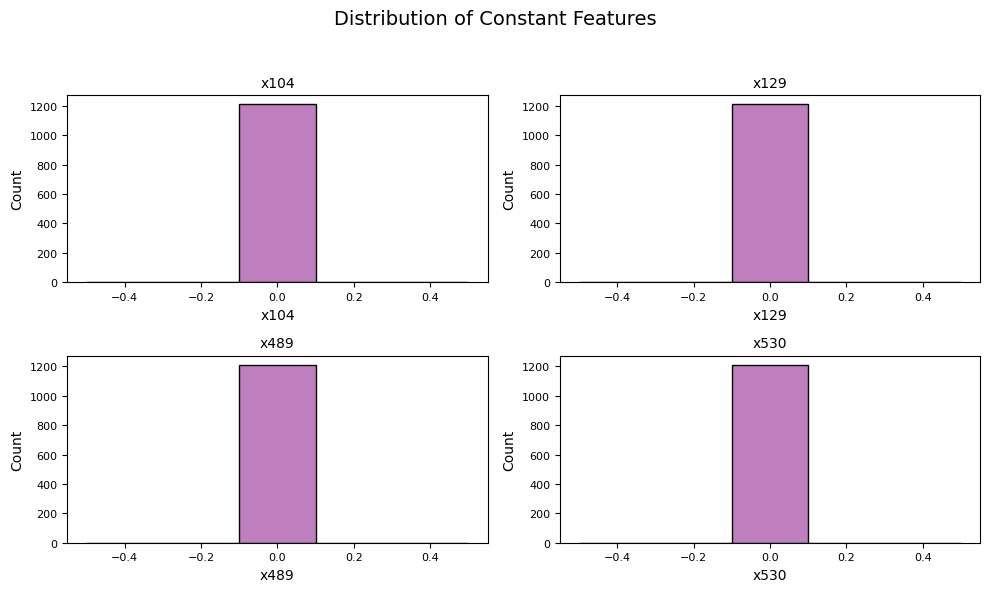


Shape after removing constant features X_impt_train: (1212, 828)
Shape after removing constant features X_imp_test: (776, 828)


In [1295]:
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE:Remove zero variance features and plot them
constant_features = X_imp_train.columns[X_imp_train.nunique() <= 1]
print(f"Found {len(constant_features)} constant features: {list(constant_features)}")

num = len(constant_features)
if num > 0:
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    for i, col in enumerate(constant_features):
        ax = axes[i]
        sns.histplot(X_imp_train[col], bins=5, kde=True, ax=ax, color='purple')
        ax.set_title(col, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    for j in range(num, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribution of Constant Features", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No constant features found.")

X_imp_train.drop(columns=constant_features, inplace=True)
X_imp_test.drop(columns=constant_features, inplace=True)

print(f"\nShape after removing constant features X_impt_train: {X_imp_train.shape}")
print(f"Shape after removing constant features X_imp_test: {X_imp_test.shape}")

Removed 55 outliers out of 1212 samples (4.54%)


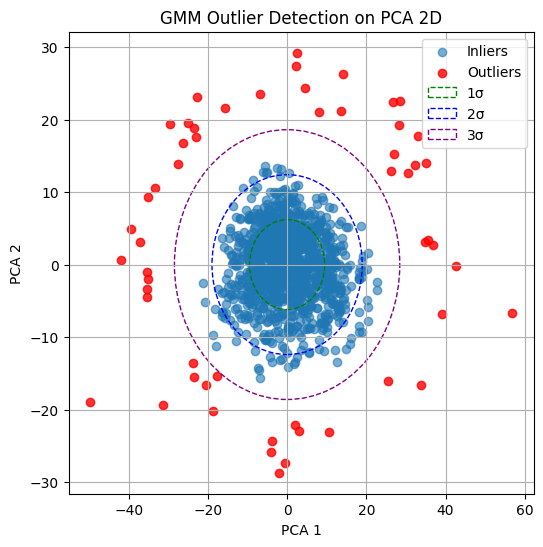

In [1296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def clean_with_gmm_pca2d(X_train, y_train, outlier_percentile=4.5):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X_scaled)

    gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    gmm.fit(X_2d)
    log_likelihood = gmm.score_samples(X_2d)

    threshold = np.percentile(log_likelihood, outlier_percentile)
    mask = log_likelihood >= threshold
    n_outliers = (~mask).sum()
    print(f"Removed {n_outliers} outliers out of {len(X_scaled)} samples ({100*n_outliers/len(X_scaled):.2f}%)")

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]

    plt.figure(figsize=(6,6))
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label='Inliers', alpha=0.6)
    plt.scatter(X_2d[~mask, 0], X_2d[~mask, 1], label='Outliers', color='red', alpha=0.8)

    def plot_gmm_ellipse(gmm, ax, n_std=2.0, facecolor='none', **kwargs):
        for mean, cov in zip(gmm.means_, gmm.covariances_):
            v, w = np.linalg.eigh(cov)
            order = v.argsort()[::-1]
            v, w = v[order], w[:, order]
            angle = np.degrees(np.arctan2(*w[:,0][::-1]))
            width, height = 2 * n_std * np.sqrt(v)
            ellip = Ellipse(xy=mean, width=width, height=height, angle=angle,
                            facecolor=facecolor, **kwargs)
            ax.add_patch(ellip)

    ax = plt.gca()
    plot_gmm_ellipse(gmm, ax, n_std=1, edgecolor='green', linestyle='--', label='1σ')
    plot_gmm_ellipse(gmm, ax, n_std=2, edgecolor='blue', linestyle='--', label='2σ')
    plot_gmm_ellipse(gmm, ax, n_std=3, edgecolor='purple', linestyle='--', label='3σ')

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('GMM Outlier Detection on PCA 2D')
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_train_clean, y_train_clean, mask, pca_2d, gmm, threshold

X_imp_train, y_train_df, mask_train, pca_2d_train, gmm_train, threshold_train = clean_with_gmm_pca2d(X_imp_train,y_train_df, outlier_percentile=4.5)

## __GRAY MATTER VOLUME__

Found 5 GM-like features:
x384    619429.757943
x385    572101.117836
x414    552549.626299
x620    647452.474630
x682    564672.902569
dtype: float64
x384 min: 619429.70681733 max: 619429.80674722 mean: 619429.7579432626
x385 min: 572101.06822529 max: 572101.16796828 mean: 572101.1178355806
x414 min: 394532.60008886 max: 738228.31524698 mean: 552549.6262986633
x620 min: 647452.42329551 max: 647452.52324221 mean: 647452.4746298423
x682 min: 564672.85337097 max: 564672.95328557 mean: 564672.9025692128


/tmp/ipykernel_23436/2983552901.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


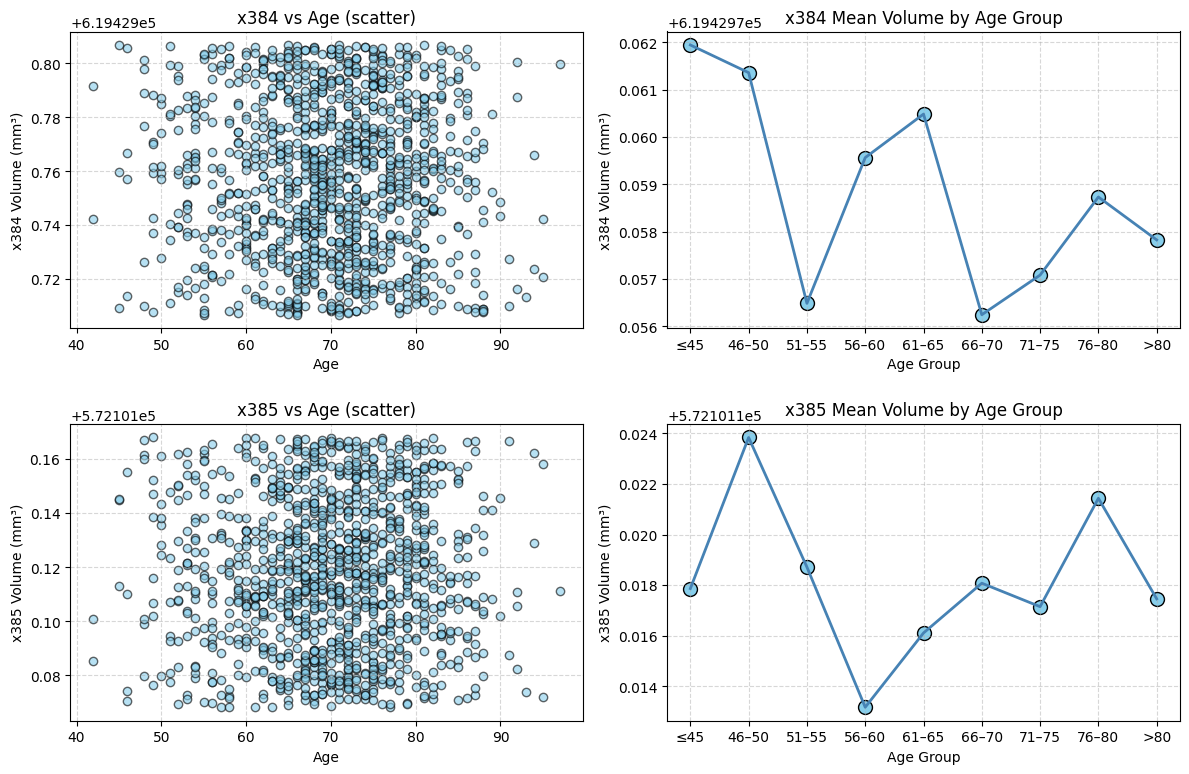

In [1297]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

gm_min_mm3 = 540 * 1000  
gm_max_mm3 = 650 * 1000  

feature_means = X_imp_train.mean()

gm_like_features = feature_means[(feature_means >= gm_min_mm3) & (feature_means <= gm_max_mm3)]
print(f"Found {len(gm_like_features)} GM-like features:")
print(gm_like_features)

for feat in gm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

top_features_gm = gm_like_features.index  

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

top_features_gm = gm_like_features.index[:2]  

n_rows = len(top_features_gm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_gm):
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __WM__

Found 6 GM-like features:
x207    494838.183322
x262    523737.965246
x281    486988.630274
x462    490255.736389
x466    475181.279406
x593    499058.359536
dtype: float64
x207 min: 494838.13510338 max: 494838.23495511 mean: 494838.18332181906
x262 min: 523737.91232576 max: 523738.01208095 mean: 523737.96524646104
x281 min: 486988.58129905 max: 486988.68119944 mean: 486988.6302735729
x462 min: 490255.68535904 max: 490255.7852076 mean: 490255.7363889067
x466 min: 475181.22918967 max: 475181.32888074 mean: 475181.2794055161
x593 min: 499058.31199378 max: 499058.41176034 mean: 499058.3595356062


/tmp/ipykernel_23436/2077042516.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


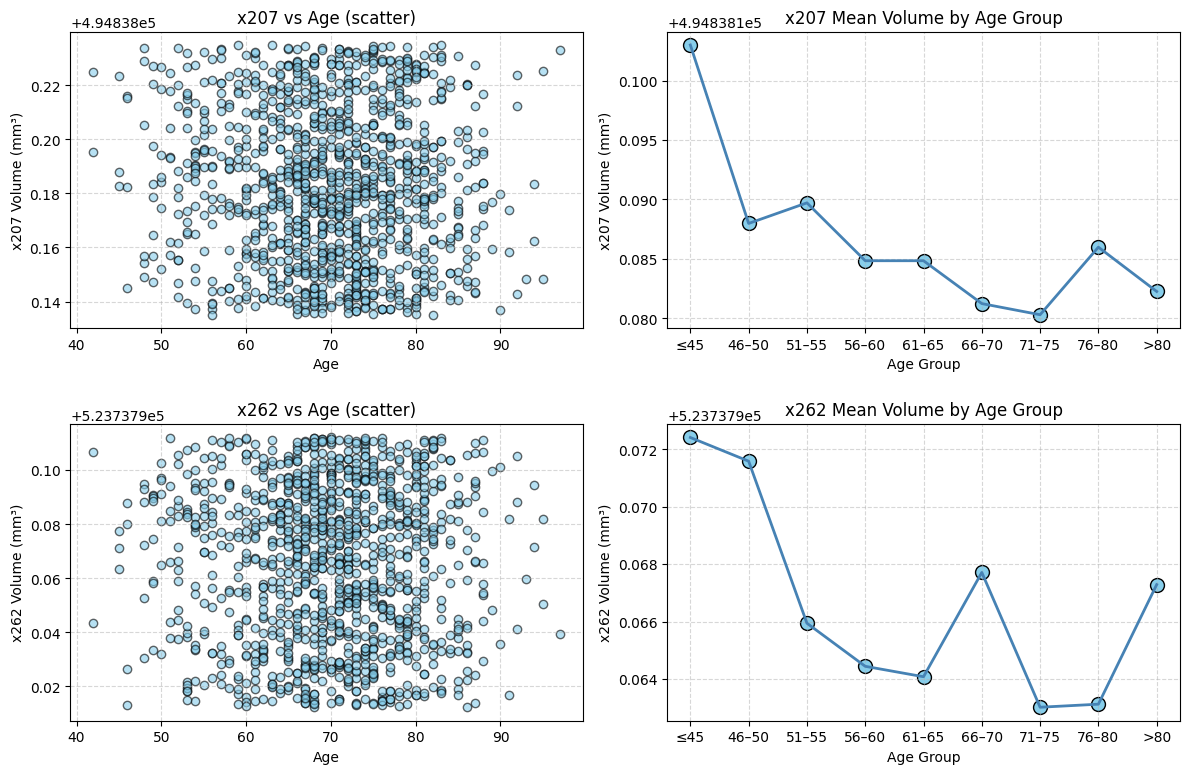

In [1298]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

wm_min_mm3 = 451 * 1000  
wm_max_mm3 = 539 * 1000  

feature_means = X_imp_train.mean()

wm_like_features = feature_means[(feature_means >= wm_min_mm3) & (feature_means <= wm_max_mm3)]
print(f"Found {len(wm_like_features)} GM-like features:")
print(wm_like_features)

for feat in wm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())


top_features_wm = wm_like_features.index  

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

top_features_wm = wm_like_features.index[:2]  

n_rows = len(top_features_wm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_wm):
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __CFS__

In [1299]:
import matplotlib.pyplot as plt

y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

cfs_min_mm3 = 330 * 1000  
cfs_max_mm3 = 450 * 1000  

feature_means = X_imp_train.mean()

cfs_like_features = feature_means[(feature_means >= cfs_min_mm3) & (feature_means <= cfs_max_mm3)]
print(f"Found {len(cfs_like_features)} GM-like features:")
print(cfs_like_features)

for feat in cfs_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

top_features_cfs = cfs_like_features.index


# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# # Select top features (or all)
# top_features_cfs = cfs_like_features.index[:2]  

# n_rows = len(top_features_cfs)
# fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_cfs):
#     # Left: scatter of individual values vs age
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)

#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)

# plt.tight_layout()
# plt.show()

Found 9 GM-like features:
x185    363704.311085
x295    388843.502354
x307    372663.102065
x492    357883.294165
x550    339510.185727
x666    349429.995173
x668    427393.987411
x675    409217.297284
x808    368045.117241
dtype: float64
x185 min: 363704.2616998 max: 363704.3616919 mean: 363704.3110847158
x295 min: 388843.45142709 max: 388843.55140818 mean: 388843.50235404755
x307 min: 372663.05125728 max: 372663.15118039 mean: 372663.10206496075
x492 min: 357883.24461822 max: 357883.3444171 mean: 357883.29416479764
x550 min: 339510.13537466 max: 339510.23503956 mean: 339510.1857265339
x666 min: 349429.94659632 max: 349430.04646383 mean: 349429.99517302326
x668 min: 253829.0760318 max: 630785.81756755 mean: 427393.9874109153
x675 min: 296575.62179915 max: 554544.83882351 mean: 409217.29728394403
x808 min: 368045.06904324 max: 368045.16894008 mean: 368045.1172406388


## __NEGATIVE CORRELATION__

In [1300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values()

top_features_negative = corr_sorted.index[:32]

# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# n_rows = len(top_features_negative[:2])
# fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_negative[:1]):
#     feat_mean = X_imp_train[feat].mean()  # compute mean
#     feat_corr = corr_with_age[feat]
    
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³| r={feat_corr:.3f}')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 0].legend()
    
#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean per Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 1].legend()

# plt.tight_layout()
# plt.show()


## __POSITIVE CORRELATIONS__

In [1301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values(ascending=False)

top_features_positive = corr_sorted.index[:32]

# Define age bins
# bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
# labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
# age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# n_rows = len(top_features_positive[:2])
# fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

# for i, feat in enumerate(top_features_positive[:1]):
#     feat_mean = X_imp_train[feat].mean()  # compute mean
#     feat_corr = corr_with_age[feat]
    
#     axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 0].set_title(f'{feat} vs Age (scatter)')
#     axes[i, 0].set_xlabel('Age')
#     axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 0].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 0].legend()
    
#     grouped_means = X_imp_train[feat].groupby(age_groups).mean()
#     axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
#     axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
#     axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
#     axes[i, 1].set_title(f'{feat} Mean per Age Group')
#     axes[i, 1].set_xlabel('Age Group')
#     axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
#     axes[i, 1].grid(True, linestyle='--', alpha=0.5)
#     axes[i, 1].legend()

# plt.tight_layout()
# plt.show()


## __NON-LINEAR CORR__

Top linear features by F-score:
Index(['x133', 'x334', 'x194', 'x485', 'x465', 'x458', 'x159', 'x415', 'x702',
       'x507', 'x654', 'x287', 'x200', 'x115', 'x712', 'x362', 'x410', 'x531',
       'x306', 'x327', 'x748', 'x349', 'x242', 'x203', 'x286', 'x254', 'x320',
       'x172', 'x452', 'x310', 'x23', 'x766', 'x146', 'x612', 'x325', 'x309',
       'x745', 'x640', 'x817', 'x484', 'x440', 'x542', 'x231', 'x213', 'x214',
       'x319', 'x543', 'x641', 'x546', 'x445', 'x538', 'x671', 'x209', 'x675',
       'x342', 'x414', 'x40', 'x777', 'x479', 'x276', 'x734', 'x233', 'x278',
       'x399', 'x29', 'x374', 'x711', 'x657', 'x69', 'x230'],
      dtype='object')
Highly skewed features: ['x413', 'x641_squared_squared', 'x641_squared', 'x115_squared_squared', 'x254_cube', 'x159_squared_squared', 'x702_squared_squared', 'x702_squared', 'x507_squared_squared', 'x415_squared_squared', 'x415_squared', 'x143', 'x531_squared_squared', 'x531_squared', 'x641', 'x542_cube', 'x115', 'x254_squared_squa

/tmp/ipykernel_23436/2799270245.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_imp_train[f"{feat}_squared_squared"] = X_imp_train[feat] ** 2
/tmp/ipykernel_23436/2799270245.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_imp_test[f"{feat}_squared_squared"] = X_imp_test[feat] ** 2
/tmp/ipykernel_23436/2799270245.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

Added 53 squared features to each dataset.
New train shape: (1157, 1040)


/tmp/ipykernel_23436/2799270245.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


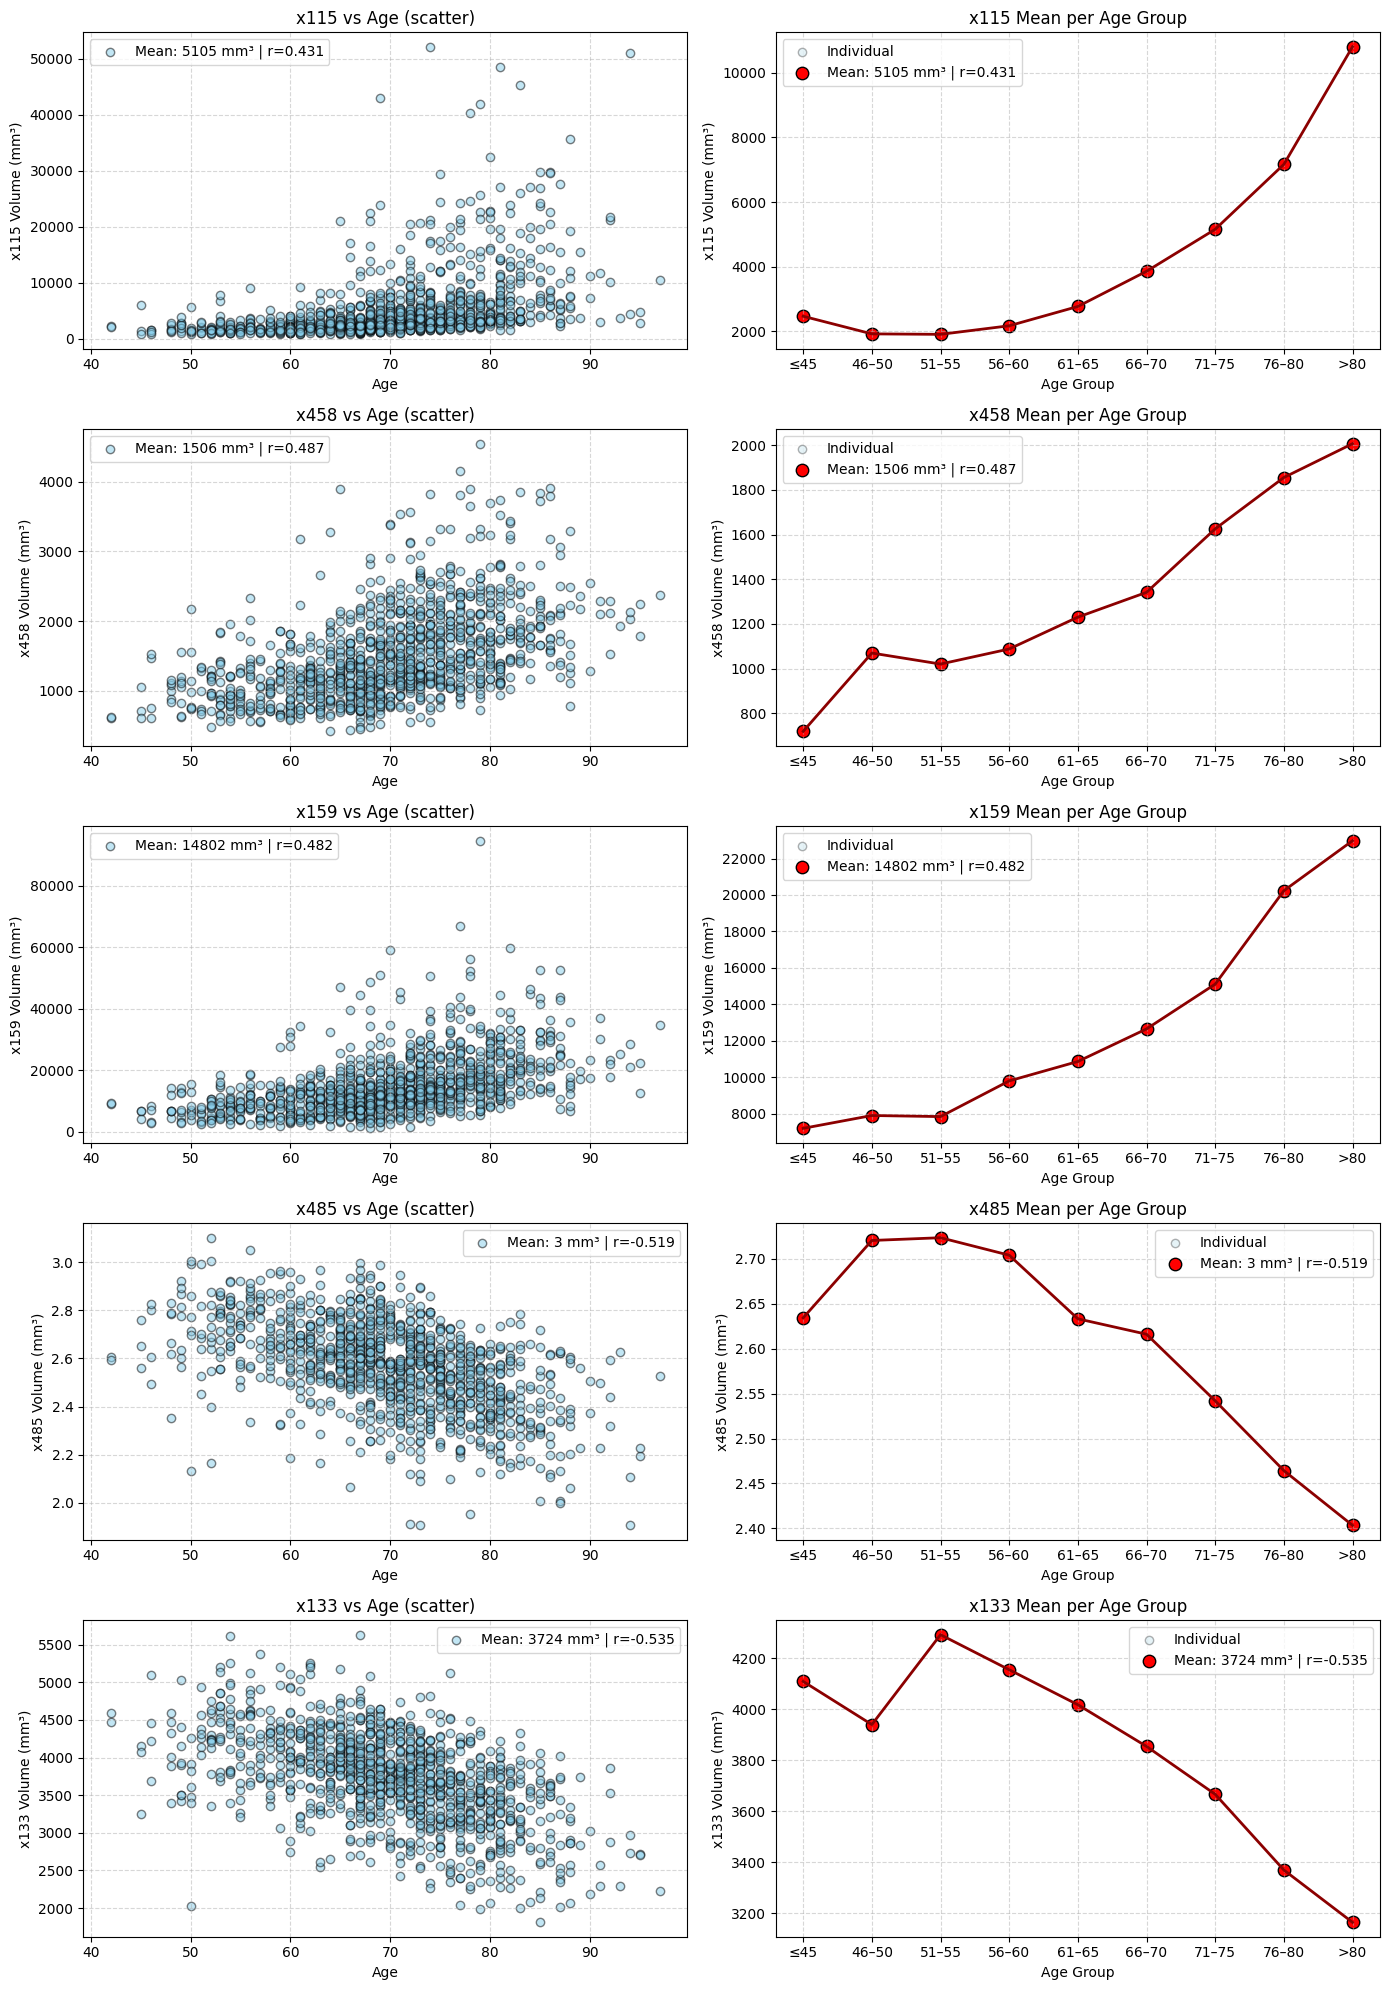

In [1302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression, f_regression
from itertools import combinations


y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

mi_scores = mutual_info_regression(X_imp_train, y_age, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_imp_train.columns)
mi_sorted = mi_scores_series.sort_values(ascending=False)


f_scores, p_values = f_regression(X_imp_train, y_age)
f_scores_series = pd.Series(f_scores, index=X_imp_train.columns)
f_sorted = f_scores_series.sort_values(ascending=False)

top_features_linear = f_sorted.index[:70]
top_features_mi = mi_sorted.index[:85]
top_features_30 = mi_sorted.index[7:60]
top_features_30_30 = mi_sorted.index[:60]
top_features_60 = mi_sorted.index[40:55]
top_features_80 = mi_sorted.index[50:75]

# mi_sorted.index[50:75].union(mi_sorted.index[120:150])

print("Top linear features by F-score:")
print(top_features_linear)

for feat in top_features_30:
    X_imp_train[f"{feat}_squared"] = X_imp_train[feat] ** 2
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_squared"] = X_imp_test[feat] ** 2

for feat in top_features_30_30:
    X_imp_train[f"{feat}_squared_squared"] = X_imp_train[feat] ** 2
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_squared_squared"] = X_imp_test[feat] ** 2

for feat in top_features_60:
    X_imp_train[f"{feat}_cube"] = X_imp_train[feat] ** 3
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_cube"] = X_imp_test[feat] ** 3

for feat in top_features_80:
    X_imp_train[f"{feat}_sqrt"] = np.sign(X_imp_train[feat]) * np.sqrt(np.abs(X_imp_train[feat]))
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_sqrt"] = np.sign(X_imp_test[feat]) * np.sqrt(np.abs(X_imp_test[feat]))

skewness = X_imp_train.skew().sort_values(ascending=False)
skewed_feats = skewness[abs(skewness) > 1.0].index 
print("Highly skewed features:", list(skewed_feats))

for feat in skewed_feats:
    X_imp_train[f"{feat}_log"] = np.sign(X_imp_train[feat]) * np.log1p(np.abs(X_imp_train[feat]))
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_log"] = np.sign(X_imp_test[feat]) * np.log1p(np.abs(X_imp_test[feat]))


# top_20_features = top_features_mi[:10]

# for f1, f2 in combinations(top_20_features, 2):
#     X_imp_train[f"{f1}_x_{f2}"] = X_imp_train[f1] * X_imp_train[f2]
#     if 'X_imp_test' in locals():
#         X_imp_test[f"{f1}_x_{f2}"] = X_imp_test[f1] * X_imp_test[f2]


print(f"Added {len(top_features_30)} squared features to each dataset.")
print(f"New train shape: {X_imp_train.shape}")

corr_with_age = X_imp_train[top_features_mi].apply(lambda x: np.corrcoef(x, y_age)[0,1])

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)


top_features_plot = top_features_mi[:5]
n_rows = len(top_features_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_plot):
    feat_mean = X_imp_train[feat].mean()
    feat_corr = corr_with_age[feat]

    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend()

    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean per Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## __CREATE DATAFRAME__

In [1303]:
# NOTE: only ones that have correlation
existing_cfs = [f for f in ['x675', 'x668'] if f in top_features_cfs]
existing_gm = [f for f in ['x414'] if f in top_features_gm]
merged_features = pd.Index(existing_gm + existing_cfs)
print(merged_features)

squared_features = [f"{feat}_squared" for feat in top_features_30 if f"{feat}_squared" in X_imp_train.columns]
cube_features = [f"{feat}_cube" for feat in top_features_60 if f"{feat}_cube" in X_imp_train.columns]
sqrt_features = [f"{feat}_sqrt" for feat in top_features_80 if f"{feat}_sqrt" in X_imp_train.columns]
log_features  = [f for f in X_imp_train.columns if f.endswith('_log')]  
squared_squared_features = [f"{feat}_squared_squared" for feat in top_features_30 if f"{feat}_squared_squared" in X_imp_train.columns]


all_selected_features_more = list(
    pd.Index(top_features_positive)
    .union(top_features_negative)
    .union(merged_features)
    .union(top_features_mi) 
    .union(top_features_linear)
    .union(squared_squared_features)
    .union(cube_features)
    .union(sqrt_features)
    .union(log_features)
)

all_selected_features_less = list(
    pd.Index(top_features_positive)
    .union(top_features_negative)
    .union(merged_features)
    .union(top_features_mi) 
    .union(top_features_linear)
    .union(squared_features)
    .union(cube_features)
)

print(f"Total selected features: {len(all_selected_features_more)}")
print(all_selected_features_more[:20]) 

X_train_final_more = X_imp_train[all_selected_features_more].copy()
X_train_final_less = X_imp_train[all_selected_features_less].copy()

X_test_final_more = X_imp_test[all_selected_features_more].copy()
X_test_final_less = X_imp_test[all_selected_features_less].copy()

X_train_final_more = X_train_final_more.astype(float)
X_train_final_less = X_train_final_less.astype(float)

X_test_final_more = X_test_final_more.astype(float)
X_test_final_less = X_test_final_less.astype(float)


print(X_train_final_more.shape)
print(X_train_final_less.shape)

print(X_test_final_more.shape)
print(X_test_final_less.shape)

print(X_train_final_more.head())

Index(['x675', 'x668'], dtype='object')
Total selected features: 264
['x113', 'x113_sqrt', 'x115', 'x115_log', 'x115_squared_squared_log', 'x132', 'x133', 'x143_log', 'x144_log', 'x146', 'x146_squared_squared', 'x151', 'x159', 'x159_log', 'x159_squared_squared_log', 'x172', 'x172_cube', 'x172_squared_squared', 'x173_log', 'x174']
(1157, 264)
(1157, 180)
(776, 264)
(776, 180)
           x113   x113_sqrt          x115  x115_log  x115_squared_squared_log  \
0  14114.997688  118.806556  12802.203605  9.457451                 18.914745   
1  16292.423778  127.641779   1921.015297  7.561130                 15.121219   
2  11899.476849  109.084723   2167.802432  7.681930                 15.362939   
4  13843.961128  117.660363   6424.918043  8.768095                 17.535878   
5  13443.587366  115.946485    786.410440  6.668750                 13.334959   

           x132         x133  x143_log  x144_log      x146  ...      x79_cube  \
0 -1.324918e+06  3562.654007  2.527393  1.188247  2.46

## __*SPLIT*__

In [1304]:
from sklearn.model_selection import train_test_split

X_train_more, X_val_more, y_train_more, y_val_more = train_test_split(X_train_final_more, y_train_df, test_size=0.25, random_state=42)

print(f"shape of X_train is : {X_train_more.shape}")
print(f"shape of y_train is : {y_train_more.shape}")
print(f"shape of X_val is : {X_val_more.shape}")
print(f"shape of y_val : {y_val_more.shape}")

X_train_more.head()

from sklearn.model_selection import train_test_split

X_train_less, X_val_less, y_train_less, y_val_less = train_test_split(X_train_final_less, y_train_df, test_size=0.25, random_state=42)

print(f"shape of X_train is : {X_train_less.shape}")
print(f"shape of y_train is : {y_train_less.shape}")
print(f"shape of X_val is : {X_val_less.shape}")
print(f"shape of y_val : {y_val_less.shape}")

X_train_less.head()

shape of X_train is : (867, 264)
shape of y_train is : (867, 1)
shape of X_val is : (290, 264)
shape of y_val : (290, 1)
shape of X_train is : (867, 180)
shape of y_train is : (867, 1)
shape of X_val is : (290, 180)
shape of y_val : (290, 1)


,x113,x115,x132,x133,x146,x146_squared,x151,x159,x172,x172_cube,...,x79,x790,x79_cube,x79_squared,x817,x817_squared,x819,x87,x87_squared,x92
396,20510.129314,3258.702191,-1.592206e+06,4093.296735,2.195183,4.818831,-74444.260457,30781.762826,2.039641,8.485188,...,-105288.097890,-123505.730073,-1.167180e+15,1.108558e+10,2.752607,7.576844,1.067796e+06,9867.075098,9.735917e+07,2.400272
1056,14206.598129,11139.774394,-1.579793e+06,3740.498018,2.076901,4.313519,-73954.476881,44360.737821,1.731995,5.195652,...,-119011.585665,-141970.684487,-1.685651e+15,1.416376e+10,2.235393,4.996980,1.104236e+06,10079.061925,1.015875e+08,3.358540
484,13432.303538,1590.959637,-1.345812e+06,3517.084894,2.310306,5.337515,-67692.678077,12362.085567,2.196716,10.600391,...,-99105.364683,-117006.406872,-9.734003e+14,9.821873e+09,2.343786,5.493333,9.184487e+05,9248.004756,8.552559e+07,2.616144
1025,14150.249489,3059.473222,-1.413684e+06,2883.304174,2.017781,4.071440,-62866.546848,20594.528758,1.822812,6.056554,...,-99567.936012,-115697.505891,-9.870940e+14,9.913774e+09,2.191930,4.804556,9.162669e+05,8663.003797,7.504763e+07,2.368442
375,12610.918517,2407.125178,-1.287224e+06,4229.539806,2.378760,5.658498,-73683.885675,16574.775755,2.000531,8.006368,...,-104103.631095,-120010.298084,-1.128230e+15,1.083757e+10,2.567518,6.592147,9.461487e+05,9795.042748,9.594286e+07,2.928486


## __STACKING BOOSTING__

XGB R² train: 0.9886, val: 0.6786
SVR R² train: 0.9684, val: 0.6851


/home/lamberto/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR R² train: 0.9997, val: 0.6882

Meta-model (Bayesian Ridge) R² val: 0.7173


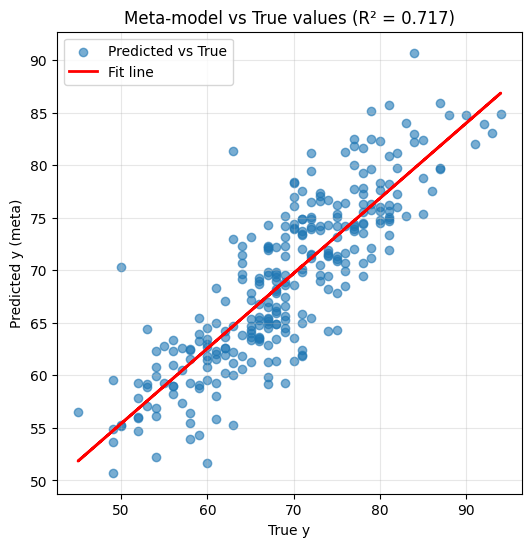

In [1305]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

y_train_more = np.ravel(y_train_more)
y_val_more = np.ravel(y_val_more)
y_train_less = np.ravel(y_train_less)
y_val_less = np.ravel(y_val_less)

r2_train_list = []
r2_val_list = []
predictions_val = {}

xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.68,
    colsample_bytree=0.7,
    reg_alpha=0.7,
    reg_lambda=2.0,
    random_state=42,
    objective='reg:squarederror',
    verbosity=0
)

xgb.fit(X_train_less, y_train_less)
y_pred_train_xgb = xgb.predict(X_train_less)
y_pred_val_xgb = xgb.predict(X_val_less)

r2_train_xgb = r2_score(y_train_less, y_pred_train_xgb)
r2_val_xgb = r2_score(y_val_less, y_pred_val_xgb)

predictions_val['xgb'] = y_pred_val_xgb
print(f"XGB R² train: {r2_train_xgb:.4f}, val: {r2_val_xgb:.4f}")

svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=24, epsilon=0.05))
])

svr.fit(X_train_more, y_train_more)
y_pred_train_svr = svr.predict(X_train_more)
y_pred_val_svr = svr.predict(X_val_more)

r2_train_svr = r2_score(y_train_more, y_pred_train_svr)
r2_val_svr = r2_score(y_val_more, y_pred_val_svr)

predictions_val['svr'] = y_pred_val_svr
print(f"SVR R² train: {r2_train_svr:.4f}, val: {r2_val_svr:.4f}")


gpr = Pipeline([
    ('scaler', StandardScaler()),                     
    ('gpr', GaussianProcessRegressor(
        kernel=0.7 * RBF(length_scale=1.5, length_scale_bounds=(0.1, 10.0)),
        n_restarts_optimizer=2,
        alpha=1e-2,                                          
        normalize_y=True,                          
        random_state=42
    ))
])

gpr.fit(X_train_more, y_train_more)
y_pred_train_gpr = gpr.predict(X_train_more)
y_pred_val_gpr = gpr.predict(X_val_more)

r2_train_gpr = r2_score(y_train_more, y_pred_train_gpr)
r2_val_gpr = r2_score(y_val_more, y_pred_val_gpr)

predictions_val['gpr'] = y_pred_val_gpr
print(f"GPR R² train: {r2_train_gpr:.4f}, val: {r2_val_gpr:.4f}")


meta_X_val = np.column_stack([y_pred_val_xgb, y_pred_val_svr, y_pred_val_gpr])
meta_model = BayesianRidge()
meta_model.fit(meta_X_val, y_val_more)

meta_pred_val = meta_model.predict(meta_X_val)
r2_meta = r2_score(y_val_more, meta_pred_val)
print(f"\nMeta-model (Bayesian Ridge) R² val: {r2_meta:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val_more, meta_pred_val, alpha=0.6, label='Predicted vs True')
coef = np.polyfit(y_val_more, meta_pred_val, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_val_more, poly1d_fn(y_val_more), color='red', lw=2, label='Fit line')

plt.xlabel("True y")
plt.ylabel("Predicted y (meta)")
plt.title(f"Meta-model vs True values (R² = {r2_meta:.3f})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


XGB R² train: 0.9884, val: 0.6679
SVR R² train: 0.9680, val: 0.6823
GPR R² train: 0.9997, val: 0.6854

Meta-model (Bayesian Ridge) R² val: 0.7090


Meta-model (Bayesian Ridge) R² val: 0.7158
GPR R² train: 0.9997, val: 0.6840
XGB R² train: 0.9887, val: 0.6763
SVR R² train: 0.9702, val: 0.6809

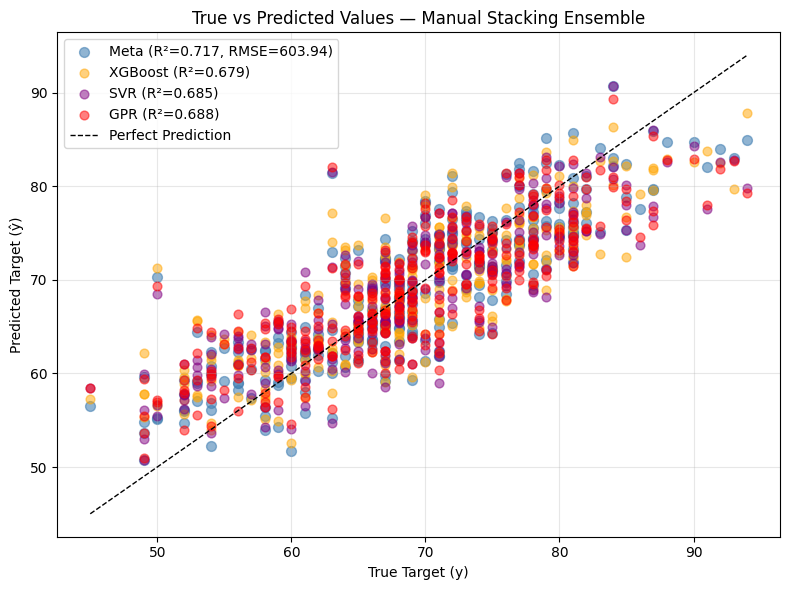

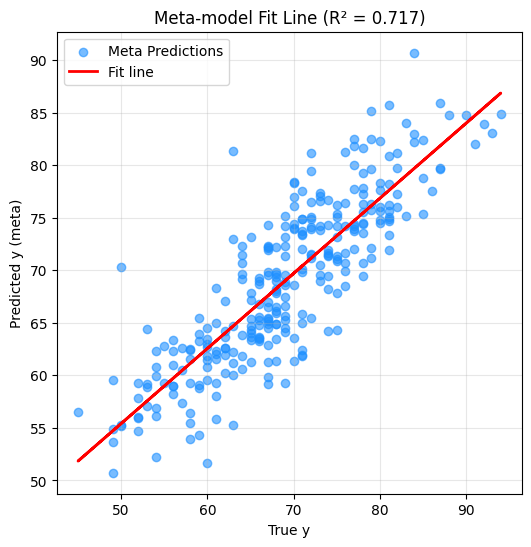

In [1306]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

r2_meta = r2_score(y_val_more, meta_pred_val)
rmse_meta = mean_squared_error(y_val_more, meta_pred_val) ** 2

plt.figure(figsize=(8, 6))

plt.scatter(
    y_val_more, meta_pred_val,
    color='steelblue', alpha=0.6, s=50,
    label=f'Meta (R²={r2_meta:.3f}, RMSE={rmse_meta:.2f})'
)

plt.scatter(y_val_less, predictions_val['xgb'], color='orange', alpha=0.5, s=40, label=f'XGBoost (R²={r2_val_xgb:.3f})')
plt.scatter(y_val_more, predictions_val['svr'], color='purple', alpha=0.5, s=40, label=f'SVR (R²={r2_val_svr:.3f})')
plt.scatter(y_val_more, predictions_val['gpr'], color='red', alpha=0.5, s=40, label=f'GPR (R²={r2_val_gpr:.3f})')

min_val = min(y_val_more.min(), meta_pred_val.min())
max_val = max(y_val_more.max(), meta_pred_val.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='Perfect Prediction')

plt.xlabel('True Target (y)')
plt.ylabel('Predicted Target (ŷ)')
plt.title('True vs Predicted Values — Manual Stacking Ensemble')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val_more, meta_pred_val, alpha=0.6, color='dodgerblue', label='Meta Predictions')
coef = np.polyfit(y_val_more, meta_pred_val, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_val_more, poly1d_fn(y_val_more), color='red', lw=2, label='Fit line')

plt.xlabel("True y")
plt.ylabel("Predicted y (meta)")
plt.title(f"Meta-model Fit Line (R² = {r2_meta:.3f})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


VAL before RMSE: 603.9432
VAL after  RMSE: 553.3202
VAL before R²:  0.7173
VAL after  R²:  0.7294


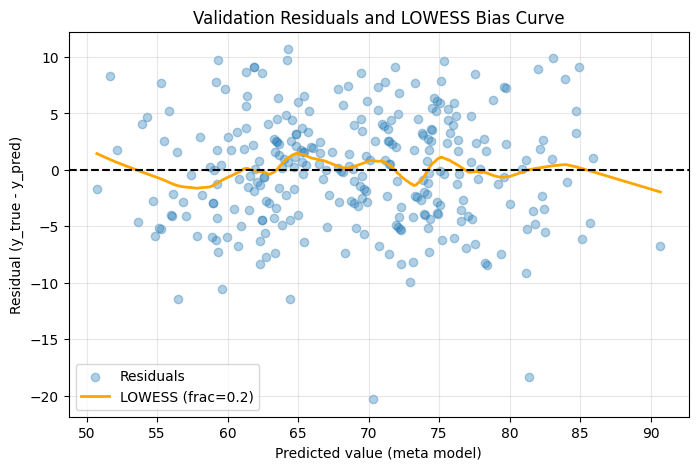

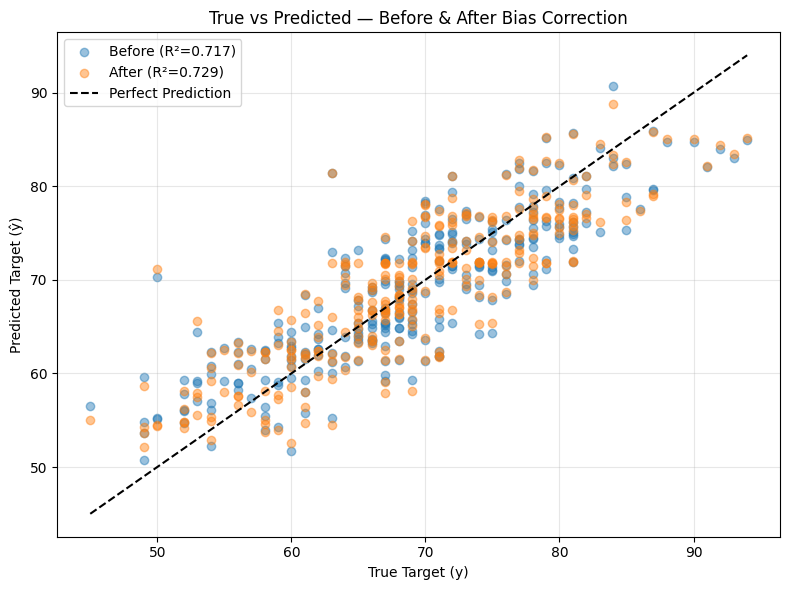

In [1308]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import interp1d

y_val = y_val_more
y_pred_val = meta_pred_val

residuals = y_val - y_pred_val

lowess = sm.nonparametric.lowess
frac = 0.2 
lowess_fit = lowess(residuals, y_pred_val, frac=frac, return_sorted=True)

xs = lowess_fit[:, 0]
ys = lowess_fit[:, 1]
bias_func = interp1d(xs, ys, bounds_error=False, fill_value=(ys[0], ys[-1]))

bias_corr_val = bias_func(y_pred_val)
y_pred_val_corrected = y_pred_val + bias_corr_val

rmse_before = mean_squared_error(y_val, y_pred_val) ** 2
rmse_after  = mean_squared_error(y_val, y_pred_val_corrected) ** 2
r2_before   = r2_score(y_val, y_pred_val)
r2_after    = r2_score(y_val, y_pred_val_corrected)

print(f"VAL before RMSE: {rmse_before:.4f}")
print(f"VAL after  RMSE: {rmse_after:.4f}")
print(f"VAL before R²:  {r2_before:.4f}")
print(f"VAL after  R²:  {r2_after:.4f}")

plt.figure(figsize=(8,5))
plt.scatter(y_pred_val, residuals, alpha=0.35, label='Residuals')
plt.plot(xs, ys, linewidth=2, color='orange', label=f'LOWESS (frac={frac})')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Predicted value (meta model)')
plt.ylabel('Residual (y_true - y_pred)')
plt.title('Validation Residuals and LOWESS Bias Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.45, label=f'Before (R²={r2_before:.3f})')
plt.scatter(y_val, y_pred_val_corrected, alpha=0.45, label=f'After (R²={r2_after:.3f})')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True Target (y)')
plt.ylabel('Predicted Target (ŷ)')
plt.title('True vs Predicted — Before & After Bias Correction')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


VAL before RMSE: 640.0072
VAL after  RMSE: 616.9622
VAL before R²:  0.7090
VAL after  R²:  0.7142

In [1309]:
import pandas as pd
import numpy as np

X_new_df = pd.read_csv("X_test.csv")
ids = X_new_df['id'].to_numpy()

X_test_final_less = X_imp_test[all_selected_features_less].copy()
X_test_final_more = X_imp_test[all_selected_features_more].copy()

y_pred_test_xgb = xgb.predict(X_test_final_less)
y_pred_test_svr = svr.predict(X_test_final_more)
y_pred_test_gpr = gpr.predict(X_test_final_more)

meta_X_test = np.column_stack([y_pred_test_xgb, y_pred_test_svr, y_pred_test_gpr])

y_pred_test = meta_model.predict(meta_X_test)

bias_corr_test = bias_func(y_pred_test)
y_pred_test_corrected = y_pred_test + bias_corr_test

submission_df = pd.DataFrame({
    'id': ids,
    'y': y_pred_test_corrected
})

submission_df.to_csv("submission103.csv", index=False)
print("✅ Submission file saved as submission.csv")


✅ Submission file saved as submission.csv


## __TEST MODEL ON UNSEEN DATA AND CREATE SUBMISSION FILE__

In [1169]:
import csv

file1 = "submission97.csv"
file2 = "submission99.csv"

with open(file1) as f1, open(file2) as f2:
    reader1 = csv.reader(f1)
    reader2 = csv.reader(f2)
    
    header1 = next(reader1)
    header2 = next(reader2)
    
    print(f"{header1[0]:<5} {header1[1]:<20}  {'Difference':<20}")
    
    for row1, row2 in zip(reader1, reader2):
        id1, y1 = row1
        id2, y2 = row2
        y1 = float(y1)
        y2 = float(y2)
        diff = abs(y1 - y2)
        print(f"{id1:<5} {y1:<20} {diff:<20}")


id    y                     Difference          
0.0   57.997234330802534   0.635926678573334   
1.0   75.60572803577317    1.1964026282638827  
2.0   69.99253858691768    1.5109634975564887  
3.0   76.36320026614784    0.28931401403752943 
4.0   72.19382200748971    0.5289123932599438  
5.0   54.03151545909688    1.364457206241994   
6.0   66.31361786151697    0.0902595718289092  
7.0   73.88588359665924    1.2947685271395528  
8.0   70.02759560805515    0.19899526613954777 
9.0   59.540558342549936   1.2432790584501134  
10.0  76.46211835853991    2.6789758123121032  
11.0  78.23056493675514    0.5466312060709839  
12.0  56.800963989873416   1.426848343832468   
13.0  72.03514978834978    0.5249493750058747  
14.0  75.40292083028702    3.704457993636538   
15.0  66.86598479821033    1.064810411304137   
16.0  75.91778757133653    1.9021131708739887  
17.0  72.66033111256951    1.1894307496426393  
18.0  66.68770209021217    1.4771511117459113  
19.0  69.20939023797926    2.0750673707